In [1]:
from google.colab import drive
drive.mount("/content/driveG")

Mounted at /content/driveG


In [2]:
#installing the necessary libraries
!pip install torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 108.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 88.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 41.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 85.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjit

In [3]:
!pip install torchinfo

In [4]:
!pip install torchvision

In [5]:
!pip install torchmetrics -U mlxtend # Install torchmetrics and mlxtend here


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 16.3 MB/s eta 0:00:00


In [6]:
!pip install timm

In [7]:
#Setting up the necessary libraries
import torch
import torchvision
from torch import nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import cv2
import numpy as np
from PIL import Image
from torchinfo import summary  # For model summary
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix
import timm


# Set manual seeds for reproducibility
torch.manual_seed(42)
torch.cuda.manual_seed(42)


In [8]:
# Define device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [9]:
# Path to the dataset inside Google Drive
train_dir = '/content/driveG/MyDrive/archive (1)/data/train'
test_dir = '/content/driveG/MyDrive/archive (1)/data/test' # Corrected path

In [10]:
# Verify that the images in the dataset is a valid image or not
import os
from PIL import Image

def remove_corrupt_images(directory):
    """
    Recursively remove corrupted image files from a directory.

    Args:
        directory (str): The path to the directory to check.
    """
    for root, _, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                with Image.open(file_path) as img:
                    img.verify()  # Verify that the file is a valid image
            except Exception as e:
                print(f"Corrupted file detected: {file_path}\nError: {e}")
                try:
                    os.remove(file_path)
                    print(f"Removed corrupted file: {file_path}")
                except Exception as remove_error:
                    print(f"Failed to remove file {file_path}. Error: {remove_error}")

# Run the removal on both training and testing directories:
remove_corrupt_images('/content/drive/MyDrive/archive (1)/data/train')
remove_corrupt_images('/content/drive/MyDrive/archive (1)/data/test')


In [11]:
def create_dataloaders(train_dir, test_dir, transform, batch_size):
    """
    Creates training and testing DataLoaders.
    """
    train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
    test_dataset  = datasets.ImageFolder(root=test_dir, transform=transform)
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_dataloader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    class_names = train_dataset.classes
    return train_dataloader, test_dataloader, class_names


In [12]:
#Data preprocessing Pipeline
# Define BilateralFilter for noise reduction
class BilateralFilter:
    def __init__(self, diameter=5, sigma_color=50, sigma_space=50):
        self.diameter = diameter
        self.sigma_color = sigma_color
        self.sigma_space = sigma_space

    def __call__(self, img):
        img_np = np.array(img)
        # If RGB, convert to grayscale first
        if len(img_np.shape) == 3 and img_np.shape[2] == 3:
            img_np = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)
        filtered = cv2.bilateralFilter(img_np, d=self.diameter,
                                       sigmaColor=self.sigma_color,
                                       sigmaSpace=self.sigma_space)
        return Image.fromarray(filtered)




In [13]:
# Define the final transformation pipeline for CNN training.
# Images are kept as 1-channel grayscale.
data_transforms = transforms.Compose([
    BilateralFilter(diameter=5, sigma_color=50, sigma_space=50),  # Noise reduction
    transforms.RandomHorizontalFlip(p=0.5),                        # Augmentation: Flip
    transforms.RandomRotation(degrees=10),                         # Augmentation: Rotate
    transforms.Grayscale(num_output_channels=1),                   # Convert to 1-channel grayscale
    transforms.CenterCrop(200),                                    # Crop edges (adjust as needed)
    transforms.Resize((224, 224)),                                 # Resize to 224x224
    transforms.ToTensor(),                                         # Convert to tensor [0,1]
    transforms.Normalize(mean=[0.5], std=[0.5]) # Normalize to [-1,1] for 1 channel
])

In [14]:
# Create DataLoaders using our transformation pipeline
train_dataloader, test_dataloader, class_names = create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=data_transforms,
    batch_size=32
)

In [16]:
!pip install timm -U

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
import timm

# DenseNet121d model for single-channel input (grayscale images)
model = timm.create_model("densenet121",
                          pretrained=True,
                          in_chans=1,
                          num_classes=1).to(device)

loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/32.3M [00:00<?, ?B/s]

In [20]:
model

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNormAct2d(
      64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): ReLU(inplace=True)
    )
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): DenseBlock(
      (denselayer1): DenseLayer(
        (norm1): BatchNormAct2d(
          64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): ReLU(inplace=True)
        )
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNormAct2d(
          128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): ReLU(inplace=True)
        )
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
  

In [21]:
model(torch.rand(1, 1, 224, 224).to(device)).shape

torch.Size([1, 1])

In [19]:
densenet121_summary = summary(model, input_size=(1, 1, 224, 224), device=device)
print(densenet121_summary)

Layer (type:depth-idx)                        Output Shape              Param #
DenseNet                                      [1, 1]                    --
├─Sequential: 1-1                             [1, 1024, 7, 7]           --
│    └─Conv2d: 2-1                            [1, 64, 112, 112]         3,136
│    └─BatchNormAct2d: 2-2                    [1, 64, 112, 112]         128
│    │    └─Identity: 3-1                     [1, 64, 112, 112]         --
│    │    └─ReLU: 3-2                         [1, 64, 112, 112]         --
│    └─MaxPool2d: 2-3                         [1, 64, 56, 56]           --
│    └─DenseBlock: 2-4                        [1, 256, 56, 56]          --
│    │    └─DenseLayer: 3-3                   [1, 32, 56, 56]           45,440
│    │    └─DenseLayer: 3-4                   [1, 32, 56, 56]           49,600
│    │    └─DenseLayer: 3-5                   [1, 32, 56, 56]           53,760
│    │    └─DenseLayer: 3-6                   [1, 32, 56, 56]           57,920


In [22]:
def train_one_epoch(model, loader, optimizer, loss_fn, device):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for X, y in loader:
        X, y = X.to(device), y.to(device).float().unsqueeze(1)
        optimizer.zero_grad()
        logits = model(X)
        loss = loss_fn(logits, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * X.size(0)
        preds = (logits > 0).float()
        correct += (preds == y).sum().item()
        total += X.size(0)
    return total_loss / total, correct / total

def evaluate(model, loader, loss_fn, device):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for X, y in loader:
            X, y = X.to(device), y.to(device).float().unsqueeze(1)
            logits = model(X)
            loss = loss_fn(logits, y)
            total_loss += loss.item() * X.size(0)
            preds = (logits > 0).float()
            correct += (preds == y).sum().item()
            total += X.size(0)
    return total_loss / total, correct / total


In [ ]:
EPOCHS = 15
results = {"train_loss": [], "train_acc": [], "test_loss": [], "test_acc": []}

for epoch in range(EPOCHS):
    train_loss, train_acc = train_one_epoch(model, train_dataloader, optimizer, loss_fn, device)
    test_loss, test_acc   = evaluate(model, test_dataloader, loss_fn, device)

    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

    print(f"Epoch {epoch+1}/{EPOCHS} - "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
          f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.6900 | train_acc: 0.5428 | test_loss: 0.7400 | test_acc: 0.4816
Epoch: 2 | train_loss: 0.6530 | train_acc: 0.6809 | test_loss: 0.7254 | test_acc: 0.4972
Epoch: 3 | train_loss: 0.6119 | train_acc: 0.7928 | test_loss: 0.7031 | test_acc: 0.4894
Epoch: 4 | train_loss: 0.5736 | train_acc: 0.8684 | test_loss: 0.6867 | test_acc: 0.5770
Epoch: 5 | train_loss: 0.5367 | train_acc: 0.9243 | test_loss: 0.6854 | test_acc: 0.5028
Epoch: 6 | train_loss: 0.5097 | train_acc: 0.9293 | test_loss: 0.6717 | test_acc: 0.5787
Epoch: 7 | train_loss: 0.4694 | train_acc: 0.9572 | test_loss: 0.6680 | test_acc: 0.6278
Epoch: 8 | train_loss: 0.4278 | train_acc: 0.9753 | test_loss: 0.6573 | test_acc: 0.6244
Epoch: 9 | train_loss: 0.3931 | train_acc: 0.9836 | test_loss: 0.6506 | test_acc: 0.6217
Epoch: 10 | train_loss: 0.3608 | train_acc: 0.9868 | test_loss: 0.6354 | test_acc: 0.6808
Epoch: 11 | train_loss: 0.3364 | train_acc: 0.9819 | test_loss: 0.6356 | test_acc: 0.6256
Epoch: 12 | train_l

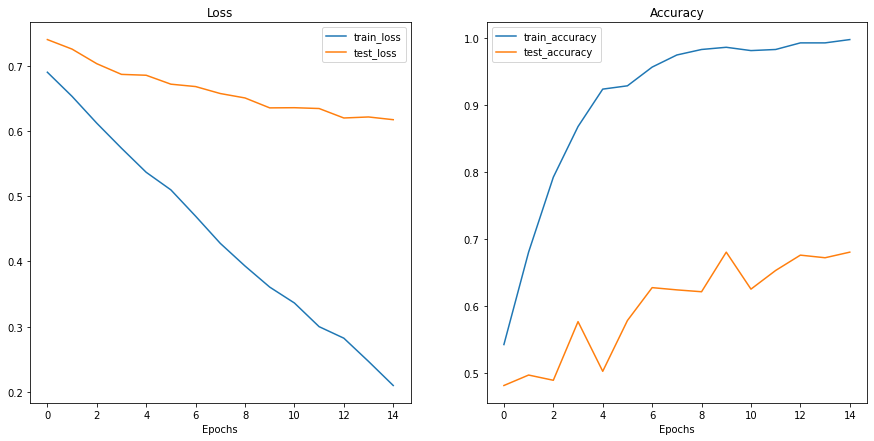

In [ ]:
import matplotlib.pyplot as plt

epochs_range = range(1, EPOCHS+1)

# Plot Loss
plt.figure(figsize=(8, 5))
plt.plot(epochs_range, results["train_loss"], label="Train Loss")
plt.plot(epochs_range, results["test_loss"], label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("DenseNet121d - Train vs Test Loss")
plt.legend()
plt.show()

# Plot Accuracy
plt.figure(figsize=(8, 5))
plt.plot(epochs_range, results["train_acc"], label="Train Accuracy")
plt.plot(epochs_range, results["test_acc"], label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("DenseNet121d - Train vs Test Accuracy")
plt.legend()
plt.show()


In [ ]:
# Plotting confusion matrix
import torchmetrics, mlxtend
print(f"mlxtend version {mlxtend.__version__}")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 KB 32.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 73.9 MB/s eta 0:00:00
  Attempting uninstall: mlxtend
    Found existing installation: mlxtend 0.14.0
    Uninstalling mlxtend-0.14.0:
      Successfully uninstalled mlxtend-0.14.0
mlxtend version 0.21.0


In [ ]:
from tqdm.auto import tqdm
y_preds = [] # list for storing the model predictions
y_targets = [] # list for storing the true labels of the test data
model.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc="Making Predictions..."):
    X, y = X.to(device), y.to(device)
    y_targets.append(y.cpu())
    y_logit = model(X).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logit))
    y_preds.append(y_pred.cpu())

# concatenating all the prediction tensors into a single prediction tensor
y_pred_tensor = torch.cat(y_preds)
y_target_tensor = torch.cat(y_targets)
y_pred_tensor[:10], y_target_tensor[:10]

Making Predictions...:   0%|          | 0/8 [00:00<?, ?it/s]

(tensor([0., 0., 1., 0., 0., 0., 0., 0., 1., 0.]),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))

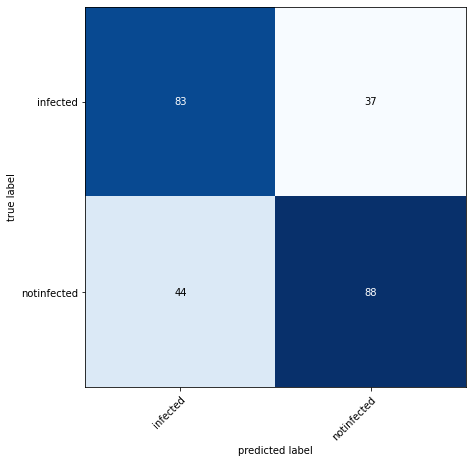

In [ ]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# Setup confusion matrix instance and compare predictions to targets
confmat = ConfusionMatrix(task="binary", num_classes=len(class_names))
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=y_target_tensor)

# Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),
    class_names=class_names,
    figsize=(10, 7)
)